# 🔮 Optimisation du Clustering des Cours

Ce notebook démontre comment améliorer le clustering des cours pour obtenir des thématiques plus distinctes et éviter la redondance des catégories comme "Machine Learning" dans tous les groupes.

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
df = pd.read_csv('data/final_data.csv')
print(f"Nombre de cours : {len(df)}")

Nombre de cours : 1983


## 1. Problématique

Actuellement, le clustering utilise des mots très fréquents comme "Machine", "Learning", "Course" qui dominent les vecteurs TF-IDF. Pour obtenir de meilleurs résultats, nous devons :
1. Ajouter des **mots vides (stop words)** personnalisés.
2. Donner plus de poids à la **catégorie** par rapport au titre.
3. Optimiser le nombre de clusters ($k$).

In [54]:
# 1. Nettoyage de la liste des mots vides
# On ENLÈVE 'machine', 'learning', 'data', 'science' pour qu'ils soient pris en compte
# custom_stop_words = [
#     'machine', 'learning', 'data', 'science',
# ]
from sklearn.feature_extraction import text
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stop_words))

# 2. Amélioration de la pondération
# On répète la catégorie 5 fois au lieu de 3 pour bien forcer le regroupement thématique
df['weighted_features'] = df.apply(
    lambda x: (str(x['category']) + ' ') * 3 + str(x['title']),
    axis=1
)

# 3. Vectorisation avec les nouveaux paramètres
tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 2) # Pour capturer "Data Science", "Web Dev", etc.
)
tfidf_matrix = tfidf.fit_transform(df['weighted_features'])

# 4. Relancer le K-means (K=12 ou 15 peut donner de meilleurs résultats ici)
k_optimal = 14

kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# 5. Analyse des clusters raffinés
for i in range(k_optimal):
    cluster_data = df[df['cluster'] == i]
    top_cats = cluster_data['category'].value_counts().head().index.tolist()
    print(f"\n🔵 Cluster {i} ({len(cluster_data)} cours) :")
    print(f"   Top Catégories: {', '.join(top_cats)}")
    print(f"   Exemples: {', '.join(cluster_data['title'].head().tolist())}")


🔵 Cluster 0 (266 cours) :
   Top Catégories: Data Science
   Exemples: Programming for Python Data Science: Principles to Practice, Data Science for Health Research, Advanced Statistical Techniques for Data Science, Introduction to Data Science Techniques, Data Science at Scale

🔵 Cluster 1 (173 cours) :
   Top Catégories: Health, Health and Fitness
   Exemples: Artificial Intelligence for Healthcare, AI in Healthcare, Introduction to Healthcare, Healthcare IT Support, Medical Administrative Assistants and the Healthcare Team

🔵 Cluster 2 (254 cours) :
   Top Catégories: Machine Learning, Language Learning
   Exemples: Applied Machine Learning, Machine Learning: Algorithms in the Real World, Databricks Machine Learning Fundamentals, Introduction to Embedded Machine Learning, Machine Learning and Reinforcement Learning in Finance

🔵 Cluster 3 (383 cours) :
   Top Catégories: History, Entrepreneurship, Psychology, Photography, Video Editing
   Exemples: Cloud Computing, Intro to Entrepr

In [55]:
df['category'].unique()

array(['Machine Learning', 'General', 'Data Science', 'Computer Science',
       'Web Development', 'Health', 'Marketing', 'Design', 'Finance',
       'Business', 'Cloud Computing', 'Cybersecurity',
       'Project Management', 'Entrepreneurship', 'Graphic Design',
       'DevOps', 'Digital Marketing', 'Information Technology',
       'Game Design', 'Health and Fitness', 'History', 'Human Resources',
       'Language Learning', 'Music Production', 'Personal Development',
       'Photography', 'Psychology', 'Video Editing'], dtype=object)

## Visualisation PCA
Nous projetons les données en 2D pour voir la séparation.

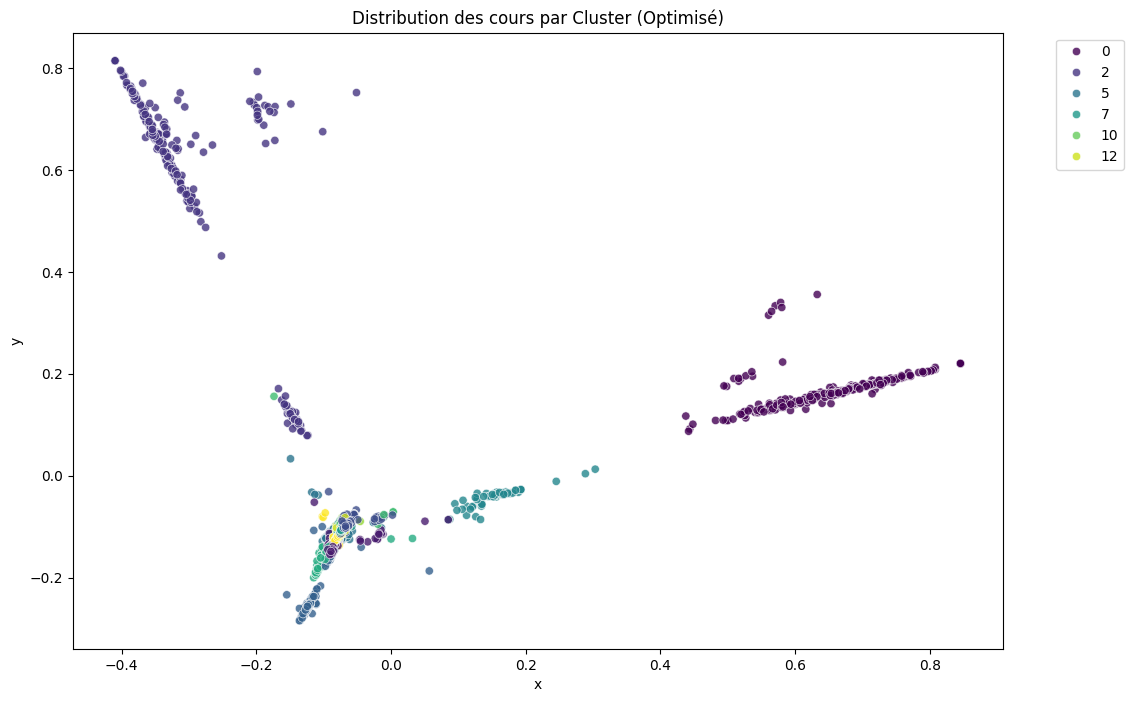

In [58]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_matrix.toarray())
df['x'], df['y'] = coords[:, 0], coords[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='viridis', alpha=0.8)
plt.title('Distribution des cours par Cluster (Optimisé)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

C:\Users\LEGION 5\AppData\Local\Temp\ipykernel_9916\1978692493.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


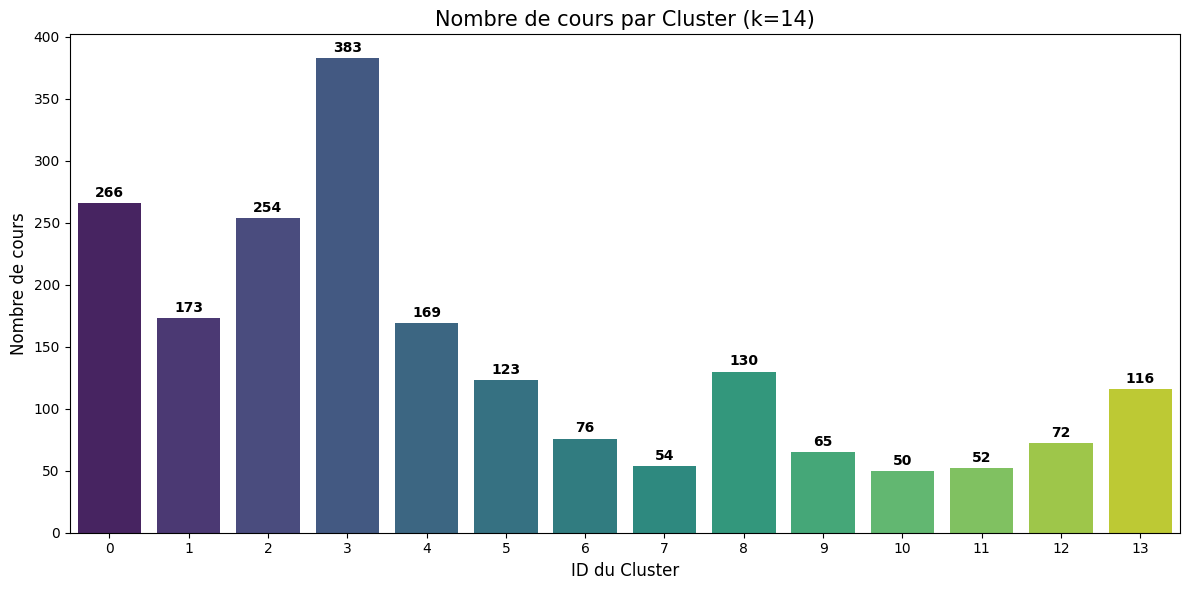

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul du nombre de cours par cluster
cluster_counts = df['cluster'].value_counts().sort_index()

# Création du Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')

# Ajout des labels et titre
plt.title('Nombre de cours par Cluster (k=14)', fontsize=15)
plt.xlabel('ID du Cluster', fontsize=12)
plt.ylabel('Nombre de cours', fontsize=12)
plt.xticks(range(k_optimal))

# Affichage des valeurs au-dessus des barres
for i, count in enumerate(cluster_counts):
    plt.text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()